## Titanic Survival Prediction Task  
-- Si Qin (05/24/2025)  

### Step 1: Data Preprocessing

In [1]:
# Supression of warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# imports necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



#### Data preprocessing includes:
1.1. Loading training data.  
1.2. Calculating the survival rate in the training data.  
1.3. Feature inspection: dimension, distribution of continuous variables, and missing values.  
1.4. Data cleaning and transformation.  
1.5. Check correlation among all features and survival.  
1.6. Using SelectKBest to investigate important features.   

In [2]:
# Load the training data
train_data0 = pd.read_csv('Titanic Survival_Assignment/train.csv')

# Display the first few rows of the training data
train_data0.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data0.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data0.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data0.shape

(891, 12)

In [6]:
# Check the survival rate
survival_rate = train_data0['Survived'].mean()
# Display the survival rate
print("Survival rate:", survival_rate)
# Check the number of missing values in survived
missing_values_surv = train_data0['Survived'].isnull().sum()
# Display the number of missing values
print("Missing values in Survived:", missing_values_surv)

Survival rate: 0.3838383838383838
Missing values in Survived: 0


Observation:  
Survival rate is 0.384, only 38.4% of people in the training data survived. Class imbalance is detected.

In [7]:
# Display the number and percentage of missing values in the training data
missing_values = train_data0.isnull().sum()
missing_percentage = (missing_values / len(train_data0)) * 100
# Display the number and percentage of missing values
print("Missing values in training data:\n", missing_values)
print("Percentage of missing values in training data:\n", missing_percentage)

Missing values in training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Percentage of missing values in training data:
 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [8]:
# Display percentage of each class in the 'Embarked' column
embarked_percentage = train_data0['Embarked'].value_counts(normalize=True) * 100
# Display the percentage of each class
print("Percentage of each class in 'Embarked':\n", embarked_percentage)

Percentage of each class in 'Embarked':
 Embarked
S    72.440945
C    18.897638
Q     8.661417
Name: proportion, dtype: float64


Observations:  
- Cabin has highest missing value rate, probably have little use, will be discard. 
- Although age also have high missing rate ~20%, since it could play an important role in survival, we will keep it, impute the missing values with median value according to different sex and Pclass groups.
- PassengerID, name and ticket probably will not provide much useful information, will be discard.
- SibSp: Number of siblings and spouse aboard the Titanic; Parch: Number of parents and children aboard the Titanic. So we can generate a maybe useful feature -- FamilySize = sibSp + Parch + 1.
- Embarked column only have 2 missing values. Using the majority value to fill it in.
- Sex and Embarked are categorical feature, we will need to encode them. 


#### 1.4. Data cleaning and transformation
According to the observation above, we will cleaning the data by:
- Drop columns: Cabin, PassengerID, Name and Ticket
- Calculate new feature FamiliSize = SibSp + Parch + 1
- Impute the missing value of age with median value according to different sex groups.
- Encode categorical features: Sex and Embarked


In [9]:
# Define a few functions needed for data transformation
# Calculate family size
def calc_family_size(df):
	return df['SibSp'] + df['Parch'] + 1
# Fill missing values in 'Age' with median value according to different classes and sexes
def fill_missing_age(df):
	return df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

def data_transformation(df):
	# Drop unnecessary columns
	df = (df
	.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1)
	# Calculate family size
	.assign(FamilySize=calc_family_size)
	# Drop SibSp and Parch columns
	.drop(['SibSp', 'Parch'], axis=1)
	# Fill missing values in 'Embarked' with most common value
	.fillna({'Embarked': train_data0['Embarked'].mode()[0]})
	# Fill missing values in 'Age' with median value according to different
	.assign(Age=fill_missing_age)
	# Encode categorical variables
	.assign(
		Embarked=lambda x: x['Embarked'].map({'C': 0, 'Q': 1, 'S': 2}),
		Sex=lambda x: x['Sex'].map({'male': 0, 'female': 1})
	)
)
	return df

# Apply the data transformation function to the training data
train_data = data_transformation(train_data0)
# train_data = (train_data0
# 	.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1)
# 	.assign(FamilySize=calc_family_size)
# 	.drop(['SibSp', 'Parch'], axis=1)
# 	# Fill missing values in 'Embarked' with most common value
# 	.fillna({'Embarked': train_data0['Embarked'].mode()[0]})
# 	# Fill missing values in 'Age' with median value according to different classes and sexes
# 	.assign(Age=fill_missing_age)
# 	# Encode categorical variables
# 	.assign(
# 		Embarked=lambda x: x['Embarked'].map({'C': 0, 'Q': 1, 'S': 2}),
# 		Sex=lambda x: x['Sex'].map({'male': 0, 'female': 1})
# 	)
# )
# Display the first 20 rows of the transformed training data
train_data.head(20)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,22.0,7.2500,2,2
1,1,1,1,38.0,71.2833,0,2
2,1,3,1,26.0,7.9250,2,1
3,1,1,1,35.0,53.1000,2,2
4,0,3,0,35.0,8.0500,2,1
5,0,3,0,25.0,8.4583,1,1
6,0,1,0,54.0,51.8625,2,1
7,0,3,0,2.0,21.0750,2,5
8,1,3,1,27.0,11.1333,2,3
9,1,2,1,14.0,30.0708,0,2


In [10]:
print("Transformed data dimentions:",train_data.shape)
train_data.describe()

Transformed data dimentions: (891, 7)


,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.112424,32.204208,1.536476,1.904602
std,0.486592,0.836071,0.477990,13.304424,49.693429,0.791503,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.500000,7.910400,1.000000,1.000000
50%,0.000000,3.000000,0.000000,26.000000,14.454200,2.000000,1.000000
75%,1.000000,3.000000,1.000000,36.000000,31.000000,2.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,11.000000


#### 1.5. Check correlation among all features and survival.  
First using Pearson 'corr()' to check the correlations. Note, pearson is only good for continuous values.

In [11]:
# Check correlation between features and Survived
correlation = train_data.corr()['Survived'].sort_values(ascending=False)
# Display the correlation
print("Correlation with Survived:\n", correlation)

Correlation with Survived:
 Survived      1.000000
Sex           0.543351
Fare          0.257307
FamilySize    0.016639
Age          -0.059579
Embarked     -0.167675
Pclass       -0.338481
Name: Survived, dtype: float64


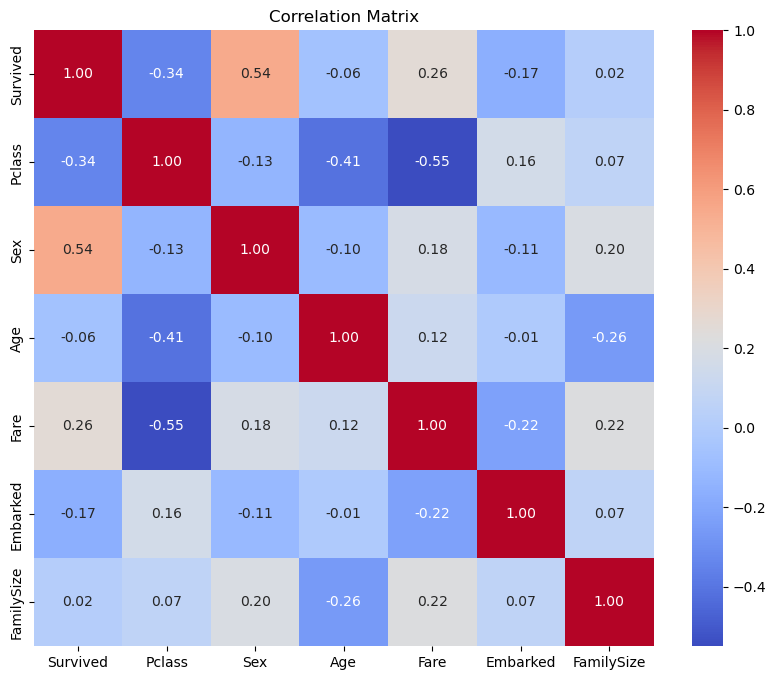

In [12]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Well, as a fast method using pearson correlation is not that great for check the correlation between continous data such as age or fare to caterogical data such as survival.  
There are a few suggestions for analyze correlations between categorical feature and continuous numeric features:
- Point-biserial for binary catergorical (survival) vs continuous (age, fare)
- Eta squared for multi-category (Pclass, Embarked) vs continuous
- Pearson for continuous-continuous
- Cramer's V for categorical-categorical

In [13]:
# import the necessary libraries
from scipy.stats import pointbiserialr, chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [14]:
# Define a function to calculate eta squared -- multi cat vs num
def eta_squared(df, cat_col, num_col):
	# Calculate eta squared
	model = ols(f'{num_col} ~ C({cat_col})', data=df).fit()
	anova = sm.stats.anova_lm(model, typ=2)
	eta_sq = anova['sum_sq'][0] / anova['sum_sq'].sum()
	return eta_sq
# Define a function to calculate cramer's V correlation -- cat vs cat
def cramers_v(x, y):
	# Create a contingency table
	crosstab = pd.crosstab(x, y)
	# Calculate chi-squared statistic
	chi2 = chi2_contingency(crosstab)[0]
	# Calculate Cramér's V
	n = crosstab.sum().sum()
	min_dim = min(crosstab.shape) - 1
	return np.sqrt(chi2 / (n * min_dim))

# Define a function for different types of correlation according to the data types
def corr_mix(df, cat_col, num_col):
	cols = cat_col + num_col
	corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

	# Check if both columns are categorical
	for col1 in cols:
		for col2 in cols:
			if col1 == col2:
				corr_matrix.loc[col1, col2] = 1.0
			# Check if both columns are numerical, then use Pearson correlation
			elif col1 in num_cols and col2 in num_cols:
				corr_matrix.loc[col1, col2] = df[[col1, col2]].corr().iloc[0, 1]
			# Check if one column is categorical and the other is numerical
			elif (col1 in cat_cols and col2 in num_cols):
				if df[col1].nunique() > 2:
					corr_matrix.loc[col1, col2] = eta_squared(df, col1, col2)
				else:
					corr_matrix.loc[col1, col2] = pointbiserialr(df[col1], df[col2])[0]
			elif (col1 in num_cols and col2 in cat_cols):
				if df[col2].nunique() > 2:
					corr_matrix.loc[col1, col2] = eta_squared(df, col2, col1)
				else:
					corr_matrix.loc[col1, col2] = pointbiserialr(df[col2], df[col1])[0]
			# Check if both columns are categorical
			elif (col1 in cat_cols and col2 in cat_cols):
				corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
	return corr_matrix

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Define the categorical and numerical columns
cat_cols = ['Survived','Sex','Embarked','Pclass']
num_cols = ['Age','Fare','FamilySize']

corr_df = corr_mix(train_data, cat_cols, num_cols)

In [17]:
corr_df

,Survived,Sex,Embarked,Pclass,Age,Fare,FamilySize
Survived,1.000000,0.540936,0.170707,0.339817,-0.059579,0.257307,0.016639
Sex,0.540936,1.000000,0.120404,0.138013,-0.102706,0.182333,0.200988
Embarked,0.170707,0.120404,1.000000,0.262340,0.009309,0.078648,0.006515
Pclass,0.339817,0.138013,0.262340,1.000000,0.173553,0.353094,0.005065
Age,-0.059579,-0.102706,0.009309,0.173553,1.000000,0.122692,-0.258456
Fare,0.257307,0.182333,0.078648,0.353094,0.122692,1.000000,0.217138
FamilySize,0.016639,0.200988,0.006515,0.005065,-0.258456,0.217138,1.000000


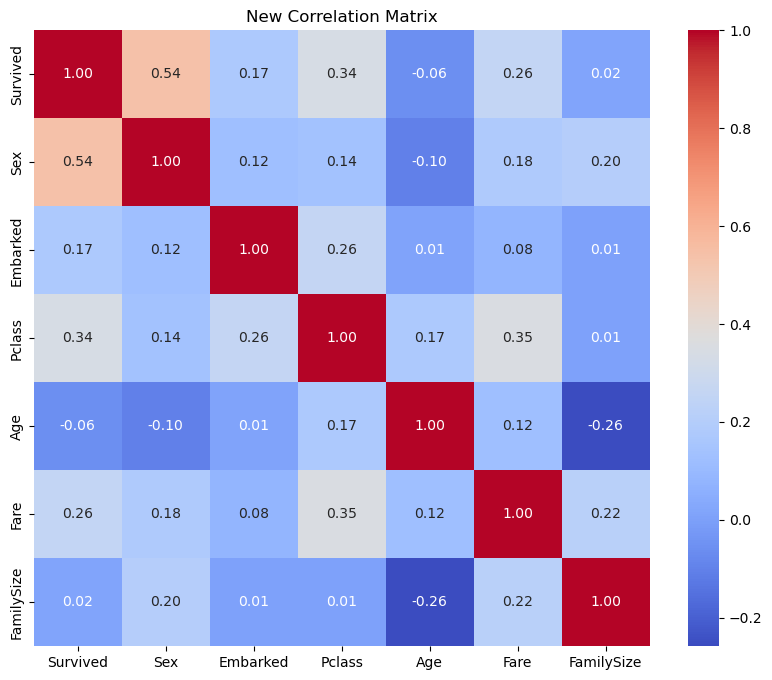

In [18]:
## Plot the new correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('New Correlation Matrix')
plt.show()

Observations:
- Survival correlates most strongly with Sex, followed by Pclass, and possible Fare. Survival shows little or no correlates with Embarked, Age or Family size.
- Pclass and Fare appear to be somewhat correlated.
- FamilySize and Age show a weak negative correlation

#### 1.6. Using SelectKBest to investigate important features.   

In [19]:
# Import the necessary libraries
from sklearn.feature_selection import SelectKBest, f_classif

# Define the features and target variable
X = train_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize']]
y = train_data['Survived']

# Apply SelectKBest to select the top 3 features
selector = SelectKBest(score_func=f_classif, k=3)
selector.fit(X, y)
# View the scores of the features, and their p-values
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_, 'P-Value': selector.pvalues_})
# Sort the features by score
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
# Display the feature scores
print("Feature scores:\n", feature_scores)



Feature scores:
       Feature       Score       P-Value
1         Sex  372.405724  1.406066e-69
0      Pclass  115.031272  2.537047e-25
3        Fare   63.030764  6.120189e-15
4    Embarked   25.717286  4.811093e-07
2         Age    3.166926  7.548531e-02
5  FamilySize    0.246193  6.198911e-01


Observations:
The SelectKBest result are consistent our correlation analysis: Age and FamilySize are weak individual predictors of survival. However, I will keep these features for now to compare simple and complex models, where nonlinear effects and interactions of these features may enhance prediction performance. I will test their contribution in the final selcted model(s).

### Step 2: Model Building and Evaluation

Based on the Module 4 course content, the following models are selected for evaluation:
- Linear Classifier: Logistic Regression (used as a baseline), Supportive vector Classifier (SVC)
- Generative Method: Naive Bayes
- Discriminant Analysis: Linear Discriminant Analysis (LDA)
- Tree based Method: Decision Tree & Random Forest
- Graph based Method: K-Nearest Neighbors (KNN)
- Boosting Method: XGBoost
- Neural Network: Multi-layer Perceptron (MLPClassifier)


In [33]:
# Import the necessary libraries

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import time

In [34]:
# Prepare the data
X = train_data.drop('Survived', axis=1)
X = pd.get_dummies(X, columns=['Pclass','Embarked'], drop_first=True)
y = train_data['Survived']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, stratify=y, random_state=42
) # add stratify to maintain the same proportion of classes in train and test sets

surv_train_rate = y_train.mean()
surv_test_rate =y_test.mean()
print("Survival rate in training set (80% in train_data):", surv_train_rate)
print("Survival rate in testing set (20% in train_data):", surv_test_rate)

Survival rate in training set (80% in train_data): 0.38342696629213485
Survival rate in testing set (20% in train_data): 0.3854748603351955


In [35]:
# Define the classifiers
classifiers = {
	'Logistic Regression': LogisticRegression(max_iter=1000), # Model tuning: Used GridSearchCV to optimize logistic regression C parameter.
	'SVM': SVC(),
	'Naive Bayes': GaussianNB(),
	'LDA': LinearDiscriminantAnalysis(),
	'Decision Tree': DecisionTreeClassifier(),
	'Random Forest': RandomForestClassifier(),
	'XGBoost': XGBClassifier(eval_metric='logloss'),
	'KNN': KNeighborsClassifier(),
	'MLP': MLPClassifier(max_iter=1000, early_stopping=True)
}

# Define the parameter grids for each classifier
grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'SVM': {
			'classifier__C': [0.1, 1, 10], 
			'classifier__kernel': ['linear', 'rbf'],
			'classifier__gamma': ['scale', 'auto']
			},
		'GaussianNB': {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]},
		'LDA': [
			{'classifier__solver': ['svd']},
			{'classifier__solver': ['lsqr', 'eigen'], 'classifier__shrinkage': ['auto', None]}
			],
		'Decision Tree': {
			'classifier__max_depth': [3, 5, 10],
			'classifier__min_samples_split': [2, 5],
			'classifier__min_samples_leaf': [1, 2],
			'classifier__criterion': ['gini', 'entropy']
			},
    'Random Forest': {
			'classifier__n_estimators': [100, 200],
			'classifier__max_depth': [3, 5, 10],
			'classifier__min_samples_split': [2, 5],
			'classifier__min_samples_leaf': [1, 2],
			'classifier__criterion': ['gini', 'entropy']
			},
		'KNN': {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance']},
		'XGBoost': {
			'classifier__n_estimators': [100, 200],
			'classifier__max_depth': [3, 5],
			'classifier__learning_rate': [0.01, 0.1]
			},
		'MLP': {
			'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
			'classifier__activation': ['relu', 'tanh'],
			'classifier__solver': ['adam', 'sgd'],
			'classifier__alpha': [0.0001, 0.001],
			'classifier__learning_rate': ['constant', 'adaptive']
			}
}

# Initialize a StratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

# Define the cross-validation and model evaluation functions
def evaluate_model(classifiers, X_train, y_train, X_test, y_test, cv):

	# Initialize a list to store the results
	results_list = []

	# Loop through the classifiers
	for name, clf in classifiers.items():
		# Create a pipeline with scaling and the classifier
		pipeline = Pipeline([
			('scaler', StandardScaler()),
			('classifier', clf)
		])
		# Define the parameter grid for GridSearchCV
		param_grid = grids.get(name)

		# Start the timer
		start_time = time.time()

		if param_grid is not None:
			# Model tuning: Used RandomizedSearchCV to optimize the hyperparameters of the classifier.
			grid = RandomizedSearchCV(
				pipeline,
				param_grid,
				cv=cv,
				scoring={'F1': 'f1', 'Accuracy': 'accuracy', 'Precision': 'precision', 'roc_auc': 'roc_auc'},
				refit='F1',
				n_jobs=1
			)
			grid.fit(X_train, y_train)
			best_estimator = grid.best_estimator_
			best_params = grid.best_params_
			best_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
		else:
			pipeline.fit(X_train, y_train)
			best_estimator = pipeline
			best_params = None

		# Cross-validate on the training set to get metric distributions
		cv_results = cross_validate(
			best_estimator, X_train, y_train, cv=cv,
			scoring={'f1': 'f1', 'accuracy': 'accuracy', 'precision': 'precision', 'roc_auc': 'roc_auc'},
			n_jobs=1, return_train_score=False
		)
		f1_scores = cv_results['test_f1'] # F1 score for each validation fold within X_train set -- not the X_test set
		acc_scores = cv_results['test_accuracy']
		prec_scores = cv_results['test_precision']
		rocauc_scores = cv_results['test_roc_auc']

		# Evaluate on the test set
		y_pred = best_estimator.predict(X_test)
		test_f1 = f1_score(y_test, y_pred, zero_division=0)
		test_acc = accuracy_score(y_test, y_pred)
		test_prec = precision_score(y_test, y_pred, zero_division=0)
		test_auc = roc_auc_score(y_test, y_pred) #if 'roc_auc' in cv_results else "Not available"


		# Feature importances or coefficients
		feature_names = X_train.columns.tolist()
		# top_features = "Not available"

		if hasattr(best_estimator.named_steps['classifier'], 'feature_importances_'):
			importances = best_estimator.named_steps['classifier'].feature_importances_
			top_features = sorted(zip(feature_names, importances), key=lambda x: -x[1])[:5]
		elif hasattr(best_estimator.named_steps['classifier'], 'coef_'):
			coefs = np.abs(best_estimator.named_steps['classifier'].coef_[0])
			top_features = sorted(zip(feature_names, coefs), key=lambda x: -x[1])[:5]
		else:
			top_features = "Not available"
					
		# Calculate the run time
		end_time = time.time()
		run_time = round(end_time - start_time, 2)

		# Append the results to the list
		results_list.append({
			'Classifier': name,
			'CV Acc Mean ± Std': f"{np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}",
			'CV F1 Mean ± Std': f"{np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}",
			'CV Prec Mean ± Std': f"{np.mean(prec_scores):.3f} ± {np.std(prec_scores):.3f}",
			'CV ROC AUC Mean ± Std': f"{np.mean(rocauc_scores):.3f} ± {np.std(rocauc_scores):.3f}",
			'Test Accuracy': test_acc,
			'Test F1': test_f1,
			'Test Precision': test_prec,
			'Test ROC AUC': test_auc,
			'Run Time (s)': run_time,
			'Top Features': top_features,
			'Best Parameters': best_params
		})

	# Convert the results list to a DataFrame and sort by test accuracy
	results = pd.DataFrame(results_list).sort_values(by='CV Acc Mean ± Std', ascending=False)
	return results

# Evaluate the models
results = evaluate_model(classifiers, X_train, y_train, X_test, y_test, cv)
print("Model evaluation results (CV and Test):\n", results.to_markdown(index=False, tablefmt="grid"))

Model evaluation results (CV and Test):
 +---------------------+---------------------+--------------------+----------------------+-------------------------+-----------------+-----------+------------------+----------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
| Classifier          | CV Acc Mean ± Std   | CV F1 Mean ± Std   | CV Prec Mean ± Std   | CV ROC AUC Mean ± Std   |   Test Accuracy |   Test F1 |   Test Precision |   Test ROC AUC |   Run Time (s) | Top Features                                                                                                                                                         | Best Parameters                                                                                            

Obeservation: 
- Model XGBoost and Random Forest show the highest accuracy, F1 score and ROC AUC. 
- Among models where features importance could be extracted, 'Sex' is always the top feature. However the predictive value of 'FamilySize' and 'Age' is uncertain. As noted earlier, we will now test if 'Age' and 'FamilySize' can be safely excluded from the dataset without significantly affecting model performance.

In [55]:
# Test whether 'Age' and 'FamilySize' can be safely dropped from the model
# Define the features and target variable
X1 = train_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize']]
X2 = train_data[['Pclass', 'Sex', 'Fare', 'Embarked']]
y = train_data['Survived']
# Split the data into training and testing sets
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=24, stratify=y) # adding stratify=y to ensure the same distribution of target variable in train and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=24, stratify=y) # adding stratify=y 
# Define the classifiers
classifiers = {
	'Random Forest': RandomForestClassifier(),
	'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Evaluate the models with and without 'Age' and 'FamilySize'
results1 = evaluate_model(classifiers, X1_train, y_train, X1_test, y_test, cv)
results2 = evaluate_model(classifiers, X2_train, y_train, X2_test, y_test, cv)

In [56]:
# Combine the results
combined_results = pd.concat([results1, results2], keys=['All', 'W/O Age & FamilySize'])
# Display the combined results
print("Combined model evaluation results (with and without 'Age' and 'FamilySize'):\n", combined_results.to_markdown(index=True, tablefmt="grid"))


Combined model evaluation results (with and without 'Age' and 'FamilySize'):
 +-----------------------------+---------------+---------------------+--------------------+----------------------+-------------------------+-----------------+-----------+------------------+----------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+
|                             | Classifier    | CV Acc Mean ± Std   | CV F1 Mean ± Std   | CV Prec Mean ± Std   | CV ROC AUC Mean ± Std   |   Test Accuracy |   Test F1 |   Test Precision |   Test ROC AUC |   Run Time (s) | Top Features                                                                                                                                                   | Best Parameters                              

Observation:  
For both Random Forest and XGBoost model, including 'Age' and 'FamilySize' clearly add predictive value, as seen in the higher CV and test metrics. XGBoost's test result metric especially F1 and ROC AUC seems more close to the CV results, suggesting greater robustness. Therefore we select XGBoot with all features as the final model.

In [57]:
# Rebuild the best model with the full training data
# {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}       
best_model = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=24)
best_model.fit(X, y)
# Save the model
import joblib
from datetime import datetime

# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Define filename with date
filename = f"best_model_SiQin_{today}.joblib"
# Save the model to a file
joblib.dump(best_model, filename)


['best_model_SiQin_2025-05-26.joblib']

### Step 3: Model Testing

In [58]:
# Load the test data
test_data0 = pd.read_csv('Titanic Survival_Assignment/holdout_test.csv')
# Display the first few rows of the test data
test_data0.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
# Display the shape of the test data
print("Shape of test data:", test_data0.shape)

Shape of test data: (418, 12)


In [60]:
# Transform the test data using the same function as for the training data
test_data = data_transformation(test_data0)
# test_data.head(20)
# Display the shape of the test data
print("Shape of test data:", test_data.shape)
# test_data.info()

Shape of test data: (418, 7)


In [61]:
# Predict the survival using the best model
X_test = test_data.drop('Survived', axis=1)
X_test = pd.get_dummies(X_test, columns=['Pclass','Embarked'], drop_first=True)	
predictions = best_model.predict(X_test)
# Save the predictions to a CSV file
submission = pd.DataFrame({'PassengerId': test_data0['PassengerId'], 'Survived': predictions})


In [62]:
# Save the submission file with today's date
submission.to_csv(f'Titanic Results from Si Qin {today}.csv', index=False)
# Display the first few rows of the submission file
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


The models evaluated here range from simple linear models (Logistic Regression, LDA) to more complex ensemble methods (Random Forest, XGBoost) and neural methods (MLP). Linear models are fast, interpretable, but assumes linear relationshiops, not ideal for complex data with nonlinear relationships. Naive Bayes and KNN models are simple and efficient but sensitive to feature scaling and data distrubution, make it challengable for their application on real-world data. Tree based models, especially ensemble methods as Random Forest and XGBoost generated quit good prediction, though they are hard to interpret and also cost more compute time. MLP, a basic neural network, can model complex patterns, but requires more tuning and longer training time. Overall, ensemble methods provided the best performance in this evaluation.    